# Import python library

In [1]:
import os
import time 
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers, optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

print("Installed tensorflow version: ", tf.__version__)

Installed tensorflow version:  2.0.0


# GPU setting

In [2]:
# Import python library

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # GPU unit setting
tf.keras.backend.floatx()

'float32'

# Parameters Setting for training

In [3]:
### RMSprop optimizer parameters
lr_begin = 1e-4

### Training parameters 
MAX_EPOCHS = 100
BATCH_SIZE = 128
EPOCH_1 = math.ceil(MAX_EPOCHS/2)
EPOCH_2 = math.ceil(MAX_EPOCHS*3/4)

# Load Dataset

In [4]:
print("[Info.] where am I?")
%pwd

[Info.] where am I?


'/home/ai/2021work/DeepLearning/plant/KSB_RNN_MultiTrend/ver0007'

In [5]:
#Normal dataset
nonleak_data = np.load('./data/nonleak_data.npy')

#Leak dataset
leak_data = np.load('./data/leak_data.npy')

print(leak_data.shape, nonleak_data.shape)

(9225, 320) (9924, 320)


In [6]:
##### Labeling
nonleak_label = np.zeros(leak_data.shape[0])   # Normal data - label 0
leak_label = np.ones(nonleak_data.shape[0])  # Leak data - label 1

print('[Info.] Number of normal dataset: ', len(nonleak_label))
print('[Info.] Number of leak dataset: ', len(leak_label))

[Info.] Number of normal dataset:  9225
[Info.] Number of leak dataset:  9924


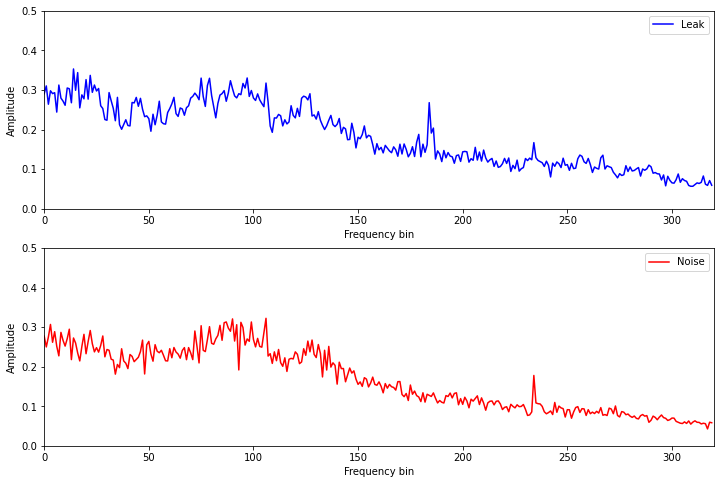

In [7]:
##### Display the measured signals
kk = 100

plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.plot(leak_data[kk,:], color='blue')
plt.xlabel('Frequency bin')
plt.ylabel('Amplitude')
plt.legend(['Leak'])
plt.axis([0, 320, 0, 0.5])

plt.subplot(2,1,2)
plt.plot(nonleak_data[kk,:], color='red')
plt.xlabel('Frequency bin')
plt.ylabel('Amplitude')
plt.legend(['Noise'])
plt.axis([0, 320, 0, 0.5])

plt.show()

# Data Shuffle

In [8]:
Train_raw = np.concatenate((nonleak_data, leak_data), axis=0)
Train_label = np.concatenate((nonleak_label, leak_label))
print(Train_raw.shape, Train_label.shape)
print(Train_label[9000:9100], Train_label[10000:10100])

(19149, 320) (19149,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [9]:
# s라는 배열에 data의 인덱스를 넣고 섞은 뒤 data와 data_label 배열에 대입.(train)
s = np.arange(Train_raw.shape[0])
np.random.shuffle(s)

data_tr = Train_raw[s]
data_tr_label = Train_label[s]
print(data_tr_label[0:100])

[1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0.
 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0.
 1. 1. 0. 1.]


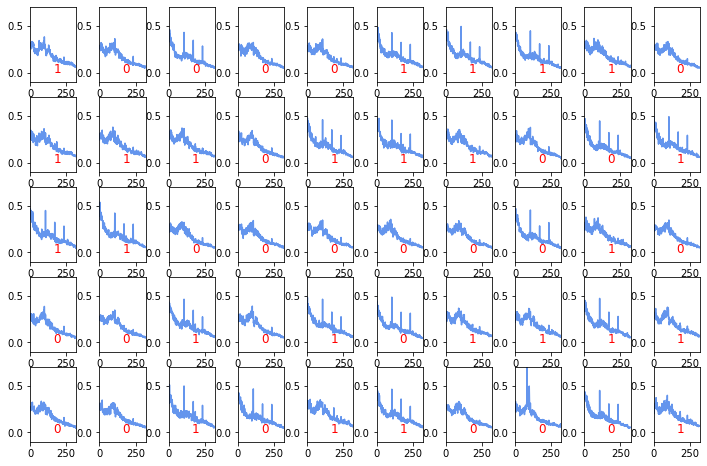

In [10]:
# Define signal plot function
def show_signal_subplot(n_show, data, label, YRNG_MIN=0, YRNG_MAX=0.5):
    plt.figure(2, figsize=(12, 8))
    plt.subplots_adjust(wspace=0.5)
    for i in range(n_show):
        plt.subplot(5, 10, i + 1)
        plt.plot(data[i], color='cornflowerblue')
        plt.text(int(data.shape[1]/2), 0, "%d" % label[i], fontsize=12, color='r')
        plt.xlim(0, data.shape[1])
        plt.ylim(YRNG_MIN, YRNG_MAX)

show_signal_subplot(50, data_tr, data_tr_label, -0.1, 0.7)

# Data Splitting - Training / test datasets

In [11]:
SPL_RATIO = 0.9 
index = round(data_tr.shape[0]*SPL_RATIO)
# train 데이터와 test 데이터로 분리
train_X, train_Y = data_tr[:index], data_tr_label[:index]
test_X, test_Y = data_tr[index:], data_tr_label[index:]

print('[Info.] Number of training dataset: ', len(train_X))
print('[Info.] Number of test dataset: ', len(test_X))

train_labels = to_categorical(train_Y)
test_labels = to_categorical(test_Y)

[Info.] Number of training dataset:  17234
[Info.] Number of test dataset:  1915


# 데이터 전처리

In [12]:
train_X_1 = np.reshape(train_X, (len(train_X),train_X.shape[1],1))
test_X_1 = np.reshape(test_X, (len(test_X),train_X.shape[1],1))

print(train_X_1.shape)
print(test_X_1.shape)

(17234, 320, 1)
(1915, 320, 1)


# 케라스 Callback 및 learning rate 설정

In [13]:
# learning rate 구간별로 설정 0.1 ~ 0.001
def lr_schedule(epoch):
    lr = lr_begin
    if epoch > EPOCH_2: # 
        lr *= 1e-2
    elif epoch > EPOCH_1:  #
        lr *= 1e-1
    print('Learning rate : ', lr)
    
    return lr 

# callback 설정 - step-decay learning rate schedule
callback_list = [LearningRateScheduler(lr_schedule)]

# Leak Detection Model

In [14]:
##### Define leak detection model function
def create_leak_detect_model(NUM_SAMPLES=train_X_1.shape[1]):
    
    network = models.Sequential()  
    network.add(layers.Conv1D(200, 3, strides=1, kernel_regularizer = None,
                                padding ='same',input_shape=(NUM_SAMPLES,1), activation='relu'))  # 1D 컨브넷 - (32,3) 유닛으로 된 밀집 층
    #network.add(layers.BatchNormalization(momentum=0.9)) #훈련하는 동안 평균,분산 이 바뀌어도 데이터 정규화 - 깊은 네트워크 구성을 위함
    network.add(layers.MaxPooling1D()) # 특성 맵 가중치 줄이기 
    network.add(layers.Conv1D(200, 3, strides=1, kernel_regularizer=None, 
                                padding='same',activation='relu')) # 1D 컨브넷 - (64,3) 유닛으로 된 밀집 층
    #network.add(layers.BatchNormalization(momentum=0.9))
    network.add(layers.MaxPooling1D())
    network.add(layers.Conv1D(400, 3, strides=1, kernel_regularizer=None, 
                                padding='same',activation='relu')) # 1D 컨브넷 - (64,3) 유닛으로 된 밀집 층
    #network.add(layers.BatchNormalization(momentum=0.9))
    network.add(layers.MaxPooling1D())    
    network.add(layers.GlobalMaxPooling1D())
    network.add(layers.Dense(600, activation='relu', kernel_regularizer=None)) #regularizers.l2(0.0001)
    #network.add(layers.BatchNormalization(momentum=0.9))
    #network.add(layers.Dropout(0.2))
    network.add(layers.Dense(200, activation='elu'))
    network.add(layers.Dropout(0.2))
    network.add(layers.Dense(2, activation='softmax'))
    
    return network

model = create_leak_detect_model()
model.summary()    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 320, 200)          800       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 160, 200)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 160, 200)          120200    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 80, 200)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 400)           240400    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 40, 400)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 400)               0

# Optimizer 설정 및 Model Compile

In [15]:
#opt = optimizers.SGD(learning_rate=lr_schedule(0), momentum=0.9, nesterov=True)
opt = optimizers.RMSprop(lr=lr_schedule(0), rho=0.8)
#opt = optimizers.Adam(lr=lr_schedule(0), beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Learning rate :  0.0001


# Model Training

In [16]:
startTime = time.time()
history = model.fit(train_X_1, train_labels, 
                    epochs = MAX_EPOCHS, 
                    batch_size = BATCH_SIZE,
                    callbacks=callback_list,
                    validation_split=0.1)
endTime = time.time()
Elapsed_time = endTime - startTime
print("/n")
print("========== [Info.] Training time:{0:.3f} min.".format(Elapsed_time/60))

Train on 15510 samples, validate on 1724 samples
Learning rate :  0.0001
Epoch 1/100
15510/15510 [==============================] - 4s 229us/sample - loss: 0.6887 - accuracy: 0.5266 - val_loss: 0.6814 - val_accuracy: 0.8370
Learning rate :  0.0001
Epoch 2/100
15510/15510 [==============================] - 2s 129us/sample - loss: 0.6334 - accuracy: 0.7186 - val_loss: 0.6274 - val_accuracy: 0.5209
Learning rate :  0.0001
Epoch 3/100
15510/15510 [==============================] - 2s 130us/sample - loss: 0.4389 - accuracy: 0.8652 - val_loss: 0.3347 - val_accuracy: 0.9263
Learning rate :  0.0001
Epoch 4/100
15510/15510 [==============================] - 2s 130us/sample - loss: 0.3069 - accuracy: 0.8924 - val_loss: 0.4752 - val_accuracy: 0.7059
Learning rate :  0.0001
Epoch 5/100
15510/15510 [==============================] - 2s 130us/sample - loss: 0.2478 - accuracy: 0.9116 - val_loss: 0.1703 - val_accuracy: 0.9582
Learning rate :  0.0001
Epoch 6/100
15510/15510 [===========================

15510/15510 [==============================] - 2s 133us/sample - loss: 0.1213 - accuracy: 0.9545 - val_loss: 0.1179 - val_accuracy: 0.9565
Learning rate :  0.0001
Epoch 48/100
15510/15510 [==============================] - 2s 135us/sample - loss: 0.1193 - accuracy: 0.9569 - val_loss: 0.1122 - val_accuracy: 0.9588
Learning rate :  0.0001
Epoch 49/100
15510/15510 [==============================] - 2s 136us/sample - loss: 0.1207 - accuracy: 0.9558 - val_loss: 0.1719 - val_accuracy: 0.9304
Learning rate :  0.0001
Epoch 50/100
15510/15510 [==============================] - 2s 136us/sample - loss: 0.1175 - accuracy: 0.9582 - val_loss: 0.1374 - val_accuracy: 0.9519
Learning rate :  0.0001
Epoch 51/100
15510/15510 [==============================] - 2s 144us/sample - loss: 0.1179 - accuracy: 0.9579 - val_loss: 0.1122 - val_accuracy: 0.9588
Learning rate :  1e-05
Epoch 52/100
15510/15510 [==============================] - 2s 142us/sample - loss: 0.1060 - accuracy: 0.9628 - val_loss: 0.1092 - val

15510/15510 [==============================] - 2s 136us/sample - loss: 0.1033 - accuracy: 0.9632 - val_loss: 0.1084 - val_accuracy: 0.9588
Learning rate :  1.0000000000000002e-06
Epoch 93/100
15510/15510 [==============================] - 2s 140us/sample - loss: 0.1036 - accuracy: 0.9632 - val_loss: 0.1085 - val_accuracy: 0.9594
Learning rate :  1.0000000000000002e-06
Epoch 94/100
15510/15510 [==============================] - 2s 139us/sample - loss: 0.1034 - accuracy: 0.9632 - val_loss: 0.1085 - val_accuracy: 0.9594
Learning rate :  1.0000000000000002e-06
Epoch 95/100
15510/15510 [==============================] - 2s 138us/sample - loss: 0.1033 - accuracy: 0.9633 - val_loss: 0.1084 - val_accuracy: 0.9588
Learning rate :  1.0000000000000002e-06
Epoch 96/100
15510/15510 [==============================] - 2s 135us/sample - loss: 0.1033 - accuracy: 0.9632 - val_loss: 0.1084 - val_accuracy: 0.9594
Learning rate :  1.0000000000000002e-06
Epoch 97/100
15510/15510 [===========================

# Plot the learning curve

In [17]:
# 부드러운 곡선 형태의 그래프 만들어주기 - exponential moving average(지수 이동 평균) 대체 
# Define smooth curve fitting function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor)) # 이동평균에 factor를 곱하고 현재 포인트에 (1- factor)를 곱해 합산
        else:
            smoothed_points.append(point)
            
    return smoothed_points

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

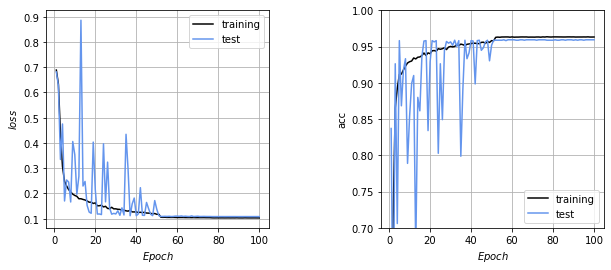

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(10, 4))
plt.subplots_adjust(wspace=0.5)

epochs = range(1, len(acc) + 1)

### Evaluated losses for training and test
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='training', color='black')
plt.plot(epochs, val_loss, label='test', color='cornflowerblue')
plt.legend()
plt.grid()
plt.xlabel('$Epoch$')
plt.ylabel('$loss$')

### Evaluated accuracies for training and test
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='training', color='black')
plt.plot(epochs, val_acc, label='test', color='cornflowerblue')
plt.ylim(0.7, 1)
plt.legend()
plt.grid()
plt.xlabel('$Epoch$')
plt.ylabel('acc')
plt.show()

# Evaluate the trained model accuracy using test dataset

In [19]:
##### Obtain test result in terms of classification accuracy
scores = model.evaluate(test_X_1, test_labels) #전체 특징 - 시험데이터 결과 
print("[INFO] test loss: {:.4f}".format(scores[0]))
print("[INFO] test accuracy: {:.4f}".format(scores[1]))

1915/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[INFO] test loss: 0.0986
[INFO] test accuracy: 0.9645


# Model Save

In [20]:
##### Save trained model
model_dir = "./save_model"
if os.path.exists(model_dir):
    pass
else:
    os.mkdir(model_dir)
    
model_path = os.path.join(model_dir, 'cnn1D_leak_model_1.h5')    
model.save(model_path)